In [8]:
!pip install mtl -q

In [9]:
from mtl.simulated_data import simulate_data
from mtl.mtl import ReweightedMTL
from mtl.cross_validation import MultiTaskLassoCV

import numpy as np
from numpy.linalg import norm

from sklearn.utils import check_random_state

import matplotlib.pyplot as plt
import seaborn as sns

## Generate and visualize data

First, let's generate some data by filling some rows of the coefficient matrix by a sine wave to which some noise is added (row-sparse matrix). Note that we normalize the matrix by the Frobenius norm.

In [10]:
X, Y, coef = simulate_data(
    n_samples=10, n_features=50, n_tasks=5, nnz=5, random_state=42
)

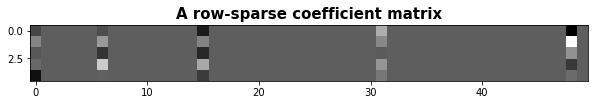

In [11]:
fig = plt.figure(figsize=(10, 7))
plt.title('A row-sparse coefficient matrix', fontweight="bold", fontsize=15)
plt.imshow(coef.T, cmap="binary");

We notice that we have created 5 non-empty rows. We want our model to recover the number of non-zero rows as well as their location. But first, let's compute the max value that $\alpha$ can take. Beyond this threshold, all the coefficients in the coefficient matrix are zero.

In [12]:
def compute_alpha_max(X, Y):
    """ 
    http://proceedings.mlr.press/v84/massias18a/massias18a.pdf
    """
    B = X.T @ Y
    b = np.linalg.norm(B, axis=1)
    return np.max(b) / X.shape[0]

In [13]:
alpha_max = compute_alpha_max(X, Y)
print('Alpha max:', alpha_max)

Alpha max: 0.22719337438816992


In [14]:
regressor = ReweightedMTL(alpha=0.01)
regressor.fit(X, Y)

Iteration 0: 0.0335
Iteration 1: 0.0271
Iteration 2: 0.0253
Iteration 3: 0.0244
Iteration 4: 0.0240


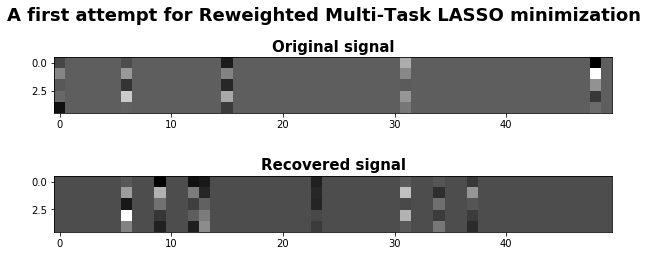

In [15]:
coef_hat = regressor.weights

fig, axes = plt.subplots(2, 1, figsize=(10, 4))

axes[0].set_title('Original signal', fontweight="bold", fontsize=15)
axes[0].imshow(coef.T, cmap="binary")

axes[1].set_title('Recovered signal', fontweight="bold", fontsize=15)
axes[1].imshow(coef_hat.T, cmap="binary")

fig.suptitle('A first attempt for Reweighted Multi-Task LASSO minimization', fontweight="bold", fontsize=18);

We notice that the recovered signal is not sparse enough. We need to adjust $\alpha$ to have the correct level or sparsity. In order to select the right value for $\alpha$, we will cross-validate the hyperparameter $\alpha$ using MultiTaskLassoCV.

## Cross-validation

The cross-validation is done over 5 folds and for $\alpha \in [0.0001,0.04]$.

In [16]:
alphas = np.geomspace(1e-3, 4e-2, num=20)
regressor = MultiTaskLassoCV(alphas, n_folds=5)

In [17]:
regressor.fit(X, Y)

Fitting MTL estimator with alpha = 0.001
Criterion reduced from inf to 0.02127 for alpha = 0.001
Fitting MTL estimator with alpha = 0.0012142802934538574
Criterion reduced from 0.02127 to 0.02125 for alpha = 0.0012142802934538574
Fitting MTL estimator with alpha = 0.0014744766310703877
Fitting MTL estimator with alpha = 0.0017904279162670054
Fitting MTL estimator with alpha = 0.00217408133557268
Criterion reduced from 0.02125 to 0.02083 for alpha = 0.00217408133557268
Fitting MTL estimator with alpha = 0.0026399441221517483
Fitting MTL estimator with alpha = 0.0032056321233482144
Fitting MTL estimator with alpha = 0.0038925359154443817
Fitting MTL estimator with alpha = 0.004726629653685488
Fitting MTL estimator with alpha = 0.005739453242924919
Fitting MTL estimator with alpha = 0.0069693049680835725
Fitting MTL estimator with alpha = 0.008462689681813946
Criterion reduced from 0.02083 to 0.02005 for alpha = 0.008462689681813946
Fitting MTL estimator with alpha = 0.010276077310241976


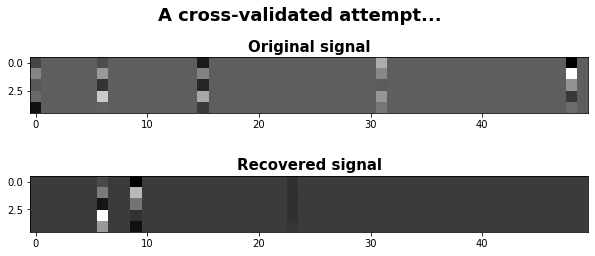

In [18]:
coef_hat = regressor.weights

fig, axes = plt.subplots(2, 1, figsize=(10, 4))

axes[0].set_title('Original signal', fontweight="bold", fontsize=15)
axes[0].imshow(coef.T, cmap="binary")

axes[1].set_title('Recovered signal', fontweight="bold", fontsize=15)
axes[1].imshow(coef_hat.T, cmap="binary")

fig.suptitle('A cross-validated attempt...', fontweight="bold", fontsize=18);

We note that 3 out of 5 non zero features are retrieved. The signal is noisy, thus we need to generate more samples to enhance our reconstruction capability.
<br/>
Now let's try LASSO on a bigger example and try to find a relation between the support recovery and the number of iterations or $\alpha$.

## A larger example. 

In [19]:
X, Y, W = simulate_data(
    n_samples=50, n_features=250, n_tasks=25, nnz=25, random_state=2020
)

In [20]:
alpha_max = compute_alpha_max(X, Y)
print('Alpha max:', alpha_max)

Alpha max: 0.0449436432001203


In [21]:
alphas = np.geomspace(1e-4, 2e-3, num=15)
regressor = MultiTaskLassoCV(alphas, n_folds=3)

In [22]:
regressor.fit(X, Y)
best_alpha = regressor.best_alpha_

Fitting MTL estimator with alpha = 0.0001


/Users/pierre-antoine/Applications/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:1953: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.727304139181148e-05, tolerance: 6.643487305882683e-05
  check_random_state(self.random_state), random)


Criterion reduced from inf to 0.00021 for alpha = 0.0001
Fitting MTL estimator with alpha = 0.00012385989684455544
Criterion reduced from 0.00021 to 0.00020 for alpha = 0.00012385989684455544
Fitting MTL estimator with alpha = 0.00015341274046343914
Criterion reduced from 0.00020 to 0.00020 for alpha = 0.00015341274046343914
Fitting MTL estimator with alpha = 0.0001900168620844211
Criterion reduced from 0.00020 to 0.00018 for alpha = 0.0001900168620844211
Fitting MTL estimator with alpha = 0.00023535468936502514
Criterion reduced from 0.00018 to 0.00017 for alpha = 0.00023535468936502514
Fitting MTL estimator with alpha = 0.00029151007546634404
Criterion reduced from 0.00017 to 0.00016 for alpha = 0.00029151007546634404
Fitting MTL estimator with alpha = 0.00036106407876409943
Criterion reduced from 0.00016 to 0.00016 for alpha = 0.00036106407876409943
Fitting MTL estimator with alpha = 0.00044721359549995795
Criterion reduced from 0.00016 to 0.00016 for alpha = 0.00044721359549995795


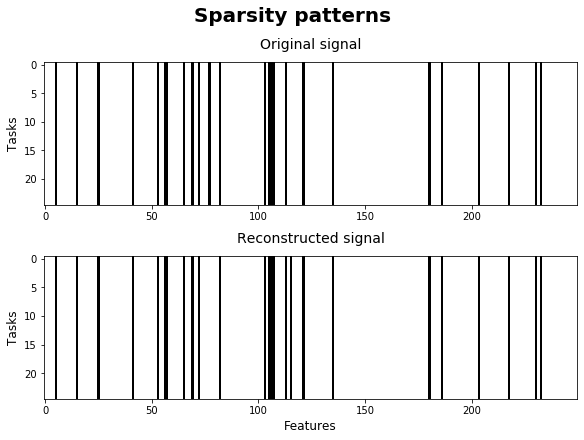

In [23]:
W_hat = regressor.weights

fig, axarr = plt.subplots(2, 1, figsize=(8, 6), constrained_layout=True)
axarr[0].spy(W.T, aspect="auto")
axarr[0].xaxis.tick_bottom()
axarr[0].set_title("Original signal", fontsize=14)
axarr[0].set_ylabel("Tasks", fontsize=12)
axarr[1].spy(W_hat.T, aspect="auto")
axarr[1].xaxis.tick_bottom()
axarr[1].set_title("Reconstructed signal", fontsize=14)
plt.suptitle("Sparsity patterns", fontweight="bold", fontsize=20)
plt.ylabel("Tasks", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.show(block=False)

It looks quite good. The rows are at the right location and it seems that the expected and the effective number of non-zero rows are equal. Let's check that...

In [24]:
nnz_original = np.count_nonzero(np.count_nonzero(W, axis=1))
nnz_reconstructed = np.count_nonzero(np.count_nonzero(W_hat, axis=1))

print('Number of non-zero rows in original:', nnz_original)
print('Number of non-zero rows in reconstructed:', nnz_reconstructed)

Number of non-zero rows in original: 25
Number of non-zero rows in reconstructed: 25


Indeed, it is the same!
<br/>
Now let's try to investigate the relationship between the support recovery and the number of iterations. 

## Support recovery and iterations

Let's take the same example as previously. We know that the true support is 25, we want to know how fast the reweighted LASSO converges to this support.

In [25]:
supports = []

In [26]:
for n_iterations in range(1, 11):
    estimator = ReweightedMTL(alpha=best_alpha, verbose=False)
    estimator.fit(X, Y, n_iterations=n_iterations)
    
    W_hat = estimator.weights
    nnz_reconstructed = np.count_nonzero(np.count_nonzero(W_hat, axis=1))
    
    supports.append(nnz_reconstructed)

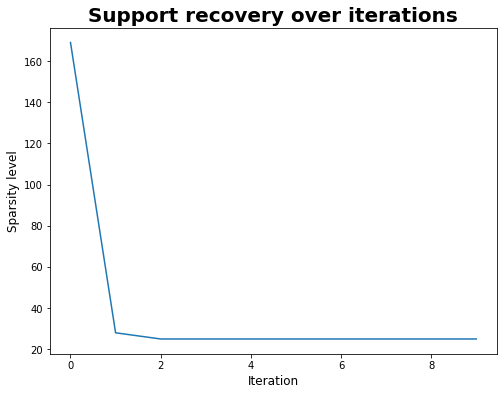

In [27]:
fig = plt.figure(figsize=(8, 6))

plt.plot(supports)
plt.title('Support recovery over iterations', fontweight="bold", fontsize=20)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Sparsity level', fontsize=12);

We see that the model converges very fast in the first iteration and zeroes out the noise quite easily. It takes the whole 10 iterations to come up with the exact number of non-zero coefficients.

## Support recovery and regularizing constant

We will now investigate the relationship between $\alpha$ and the sparsity level. Obviously, we expect that the larger $\alpha$, the larger the sparsity level. Let's verify this intuition.

In [28]:
supports = []
alphas = np.geomspace(1e-4, 2e-2, num=15)

In [29]:
for alpha in alphas:
    estimator = ReweightedMTL(alpha=alpha, verbose=False)
    estimator.fit(X, Y)
    
    W_hat = estimator.weights
    nnz_reconstructed = np.count_nonzero(np.count_nonzero(W_hat, axis=1))
    
    supports.append(nnz_reconstructed)

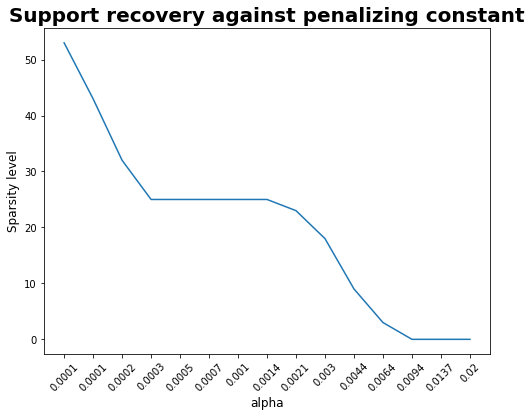

In [30]:
fig = plt.figure(figsize=(8, 6))

xlabels = [str(round(x, 4)) for x in alphas]

plt.plot(supports)
plt.title('Support recovery against penalizing constant', fontweight="bold", fontsize=20)
plt.xlabel('alpha', fontsize=12)
plt.xticks(np.arange(len(alphas)), xlabels)
plt.xticks(rotation=45)
plt.ylabel('Sparsity level', fontsize=12);

Indeed, we find that the larger alpha, the smaller the support and that at around 0.02, the support is empty.